# MDL roll decay system identification 2
Investigate if adding some item to the roll diff equation can give better results?

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [42]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import signal_lab


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [148]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.99)
scaler = ScaleFactorTransformer(scale_factor=None)  # dummy value None for now
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(0.1))

In [149]:
steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
]

transformer = Pipeline(steps)

In [150]:
roll_decay_tests = db.session.query(Run).filter(Run.test_type=='roll decay')

In [151]:
def load(db_run):
    
    ascii_file = db_run.load()
    df_raw = ascii_file.channels
    
    df = signal_lab.mdl_to_evaluation.do_transforms(df=df_raw)
    df.rename(columns={'MA/Roll':'phi'}, inplace=True)
    
    return df

In [168]:
db_run = roll_decay_tests[0]

In [169]:
df_raw = load(db_run)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [170]:
transformer['scaler'].scale_factor = db_run.model.scale_factor
transformer.fit(df_raw)
df = transformer.transform(df_raw)

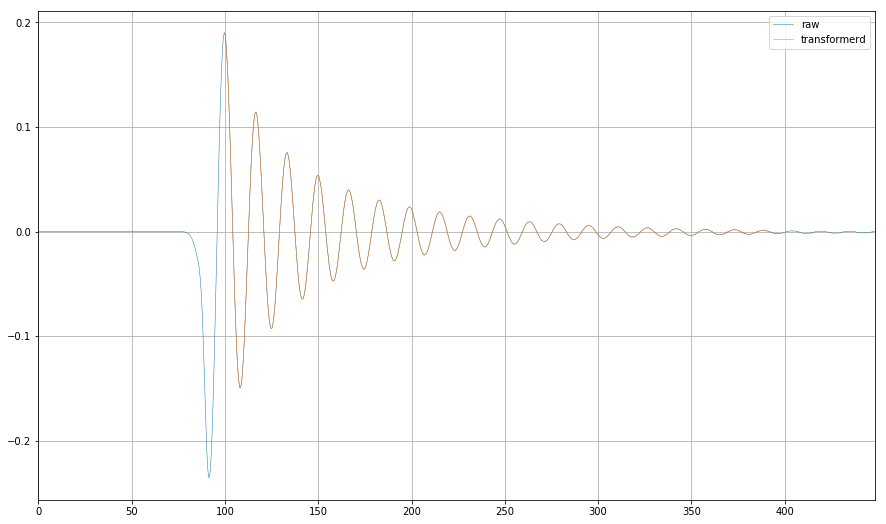

In [171]:
fig,ax = plt.subplots()

x = df_raw.index*np.sqrt(db_run.model.scale_factor)
y = df_raw['phi']
ax.plot(x,y, label='raw')
df.plot(y='phi',ax=ax, label='transformerd');
ax.grid(True)
ax.legend();


In [172]:
df.head()

,prop.tr sb,prop.tr bb,mom sb,mom bb,hj. mom,acc x,acc y1 f,acc y2 a,acc z1 bb f,acc z2 a,acc z3 sb f,delta,varv sb,varv bb,Carriage/Xp_west,Carriage/Xp_east,Carriage/Yp,Carriage/dXp,Carriage/Psip,MA/Alfa,MA/Beta,MA/Gamma,MA/Delta,MA/Torkorr,phi,MA/Pitch,våghöjd pg,phi_filtered,phi1d,phi2d
99.673708,-0.086573,0.235301,-0.033163,0.035461,0.016202,0.016320,-2.11442,-2.01717,0.466067,0.212840,-0.103122,0.000178,0.306796,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001571,-0.021817,0.001833,-0.006981,-1.0,0.190066,-0.001396,-0.000184,0.189687,0.001182,-0.026925
99.822032,0.037480,0.177163,-0.033163,0.035461,0.008550,-0.017191,-2.07920,-2.03559,0.487623,0.245279,-0.082867,0.000178,-0.306796,-0.613592,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001484,-0.021904,0.002007,-0.006720,-1.0,0.189805,-0.001396,-0.000184,0.189566,-0.002789,-0.026579
99.970356,-0.086573,0.235301,-0.035933,0.032627,-0.002929,0.016320,-2.09681,-2.01717,0.466067,0.229059,-0.103122,0.000866,-0.613592,-0.613592,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001484,-0.021904,0.002182,-0.006458,-1.0,0.188932,-0.001484,-0.000184,0.188859,-0.006703,-0.026158
100.118680,0.037480,0.177163,-0.035933,0.035461,-0.025887,-0.000435,-2.09681,-2.01717,0.466067,0.261498,-0.103122,0.000522,0.000000,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001396,-0.021991,0.002356,-0.006109,-1.0,0.187536,-0.001484,-0.000184,0.187577,-0.010549,-0.025665
100.267004,-0.024546,0.177163,-0.033163,0.035461,-0.025887,-0.000435,-2.06159,-1.99876,0.444511,0.212840,-0.042358,-0.000511,-0.613592,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001309,-0.021991,0.002443,-0.005847,-1.0,0.185528,-0.001484,-0.000184,0.185730,-0.014316,-0.025104


In [173]:
phi = df['phi']
phi1d = df['phi1d']
phi2d = df['phi2d']

X = pd.DataFrame()
X['phi1d'] = phi1d
X['phi2d'] = phi2d

y = df['phi']

linear_regression1 = LinearRegression()
linear_regression1.fit(X=X,y=y)
df_prediction1 = X.copy()
df_prediction1['phi'] = linear_regression1.predict(X=X)
linear_regression1.score(X=X, y=y)

0.9985765922327172

In [174]:
phi = df['phi']
phi1d = df['phi1d']
phi2d = df['phi2d']

X = pd.DataFrame()
X['phi1d'] = phi1d
X['phi1d*|phi1d|'] = phi1d*np.abs(phi1d)
X['phi2d'] = phi2d

y = df['phi']

linear_regression2 = LinearRegression()
linear_regression2.fit(X=X,y=y)
df_prediction2 = X.copy()
df_prediction2['phi'] = linear_regression2.predict(X=X)
linear_regression2.score(X=X, y=y)

0.9991470549981799

Text(0.5, 0, 'Time t [s] (full scale)')

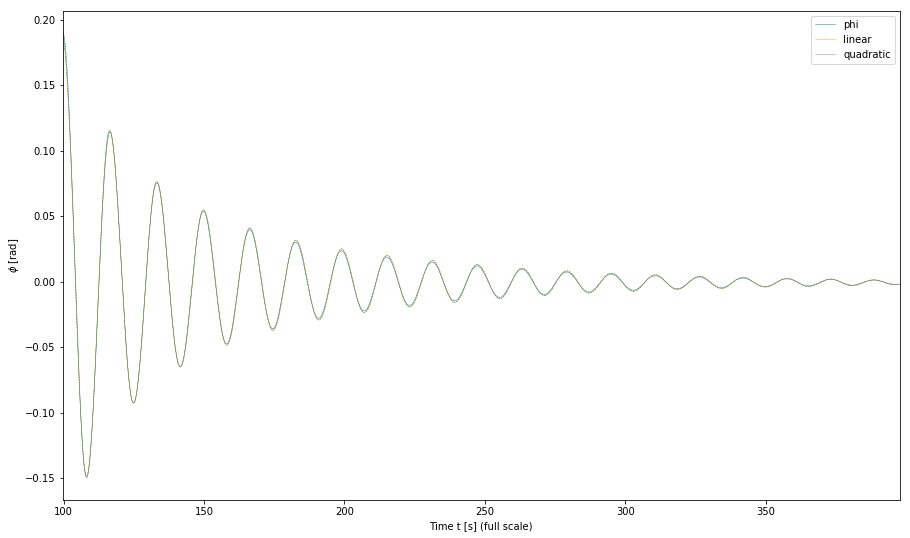

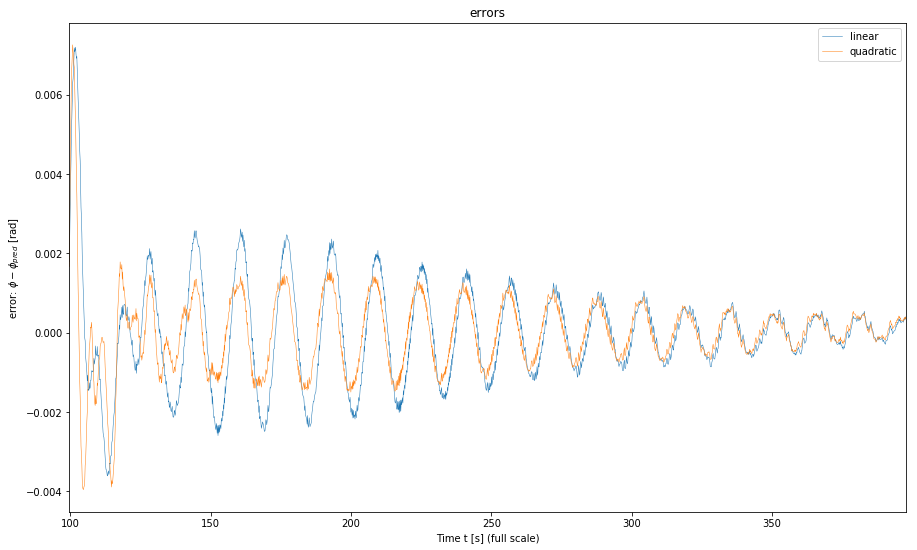

In [175]:
fig,ax = plt.subplots()
df.plot(y='phi', ax=ax)
df_prediction1.plot(y='phi', label='linear', style='--', ax=ax)
df_prediction2.plot(y='phi', label='quadratic', style='--', ax=ax)

ax.set_ylabel('$\phi$ [rad]')
ax.set_xlabel('Time t [s] (full scale)')

fig,ax = plt.subplots()
df_error1= df - df_prediction1
df_error2= df - df_prediction2
df_error1.plot(y='phi', ax=ax, label='linear')
df_error2.plot(y='phi', ax=ax, label='quadratic')
ax.set_title('errors')
ax.set_ylabel('error: $\phi-\phi_{pred}$ [rad]')
ax.set_xlabel('Time t [s] (full scale)')

